# Hackaton BBVA - Reto Retargeting - BigMinds Team

## Carga y descripción estadística del dataset

In [1]:
import pandas as pd

In [2]:
!pip install fsspec
!pip install gcsfs

In [7]:
dataset = pd.read_csv('gs://bbva-hackaton-bigminds/application_record_(experimentation).csv', header=0)
dataset.drop(columns=["ID"], inplace=True)

In [8]:
dataset.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [9]:
dataset.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


## Generación de valores para el target para el dataset

Considerando que el dataset utilizado no cuenta con valores para el target y que la tasa de conversión del canal de retargeting actual (call-center) es de 5.75%, se procederá a generar dichos valores para formar un dataset desbalanceado con un ratio 94(0):6(1), que represente la tasa de conversión anteriormente mencionada, donde "0" representa a los clientes que pasaron la evaluación de riesgo pero que no terminaron con el proceso hasta la activación de la tarjeta de crédito mediante el canal de retargeting actual, y "1" representa a los que sí terminaron con el proceso.

In [19]:
from sklearn.datasets import make_classification
from collections import Counter

In [25]:
X_gen, y_gen = make_classification(n_samples=438557, n_features=2, n_redundant=0, n_clusters_per_class=1, weights=[0.94], flip_y=0, random_state=1)

In [26]:
counter = Counter(y_gen)
print(counter)

Counter({0: 412244, 1: 26313})


## Formación de los subsets

In [27]:
from sklearn.model_selection import train_test_split

In [93]:
y= y_gen.copy()
X= dataset

### Se separa una porción para cargarlo por la página web

In [96]:
X_exp, X_testing_webpage, y_exp, y_testing_webpage = train_test_split(X, y, stratify=y, test_size=0.0002, random_state=1)

### Se forman los subsets de entrenamiento y prueba

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_exp, y_exp, stratify=y_exp, test_size=0.2, random_state=1)

## Preprocesamiento de los Datos

### Verificacion de valores faltantes

In [30]:
cols = X_train.isna().sum()
print(cols)

CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        107318
CNT_FAM_MEMBERS             0
dtype: int64


### Se eliminan las características con muchos valores faltantes

In [33]:
columnas_eliminadas = X_train.columns[X_train.isnull().mean() >= 0.3].tolist()
X_train.drop(columns = columnas_eliminadas, inplace = True)
X_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
358501,F,N,Y,0,292500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22224,365243,1,0,0,0,2.0
115820,M,N,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-9973,-1465,1,0,0,0,3.0
140501,F,N,N,2,72000.0,Working,Incomplete higher,Married,House / apartment,-10762,-2216,1,0,0,0,4.0
163776,F,Y,Y,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-20195,365243,1,0,0,0,2.0
220527,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-19990,-4873,1,0,0,0,2.0


In [34]:
print(columnas_eliminadas)

['OCCUPATION_TYPE']


### Imputación de datos

In [36]:
import numpy as np
import statistics as st
from pprint import pprint

In [37]:
X_train.columns

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS'],
      dtype='object')

#### Se utiliza a la media para las características numéricas

In [39]:
lst_caract_num = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

medias_dict = {}
for columna in lst_caract_num:
    media_caract = X_train[columna].astype("float").mean(axis=0)
    medias_dict[columna] = media_caract
    X_train[columna].replace(np.nan, media_caract, inplace=True)
    
pprint(medias_dict)

{'AMT_INCOME_TOTAL': 187576.8437814704,
 'CNT_CHILDREN': 0.4261625504140005,
 'CNT_FAM_MEMBERS': 2.1936125639527426,
 'DAYS_BIRTH': -16001.36916872123,
 'DAYS_EMPLOYED': 60594.212298878425}


#### Se utiliza a la moda para las características categóricas

In [40]:
lst_caract_categ = [
    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL'
]

modas_dict = {}
for columna in lst_caract_categ:
    moda_caract = st.mode(X_train[columna])
    modas_dict[columna] = moda_caract
    X_train[columna].replace(np.nan, moda_caract, inplace=True)

pprint(modas_dict)

{'CODE_GENDER': 'F',
 'FLAG_EMAIL': 0,
 'FLAG_MOBIL': 1,
 'FLAG_OWN_CAR': 'N',
 'FLAG_OWN_REALTY': 'Y',
 'FLAG_PHONE': 0,
 'FLAG_WORK_PHONE': 0,
 'NAME_EDUCATION_TYPE': 'Secondary / secondary special',
 'NAME_FAMILY_STATUS': 'Married',
 'NAME_HOUSING_TYPE': 'House / apartment',
 'NAME_INCOME_TYPE': 'Working'}


In [41]:
cols = X_train.isna().sum()
print(cols)

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
CNT_FAM_MEMBERS        0
dtype: int64


### Corrección de los tipos de datos de las características

In [42]:
X_train.dtypes

CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
CNT_FAM_MEMBERS        float64
dtype: object

In [43]:
for columna in lst_caract_categ:
    X_train[columna] = X_train[columna].astype('category')

In [44]:
X_train.dtypes

CODE_GENDER            category
FLAG_OWN_CAR           category
FLAG_OWN_REALTY        category
CNT_CHILDREN              int64
AMT_INCOME_TOTAL        float64
NAME_INCOME_TYPE       category
NAME_EDUCATION_TYPE    category
NAME_FAMILY_STATUS     category
NAME_HOUSING_TYPE      category
DAYS_BIRTH                int64
DAYS_EMPLOYED             int64
FLAG_MOBIL             category
FLAG_WORK_PHONE        category
FLAG_PHONE             category
FLAG_EMAIL             category
CNT_FAM_MEMBERS         float64
dtype: object

### Selección de características

In [37]:
!pip install seaborn

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

#### Agrupación de características numéricas

In [45]:
caract_num = X_train[lst_caract_num]
caract_num.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
358501,0,292500.0,-22224,365243,2.0
115820,1,157500.0,-9973,-1465,3.0
140501,2,72000.0,-10762,-2216,4.0
163776,0,157500.0,-20195,365243,2.0
220527,0,202500.0,-19990,-4873,2.0


#### Cálculo de los coeficientes correlación de Pearson entre características numéricas

In [46]:
def graficar_corr_num(data):
    correlation = data.corr()
    sns.set(font_scale=1.20)
    plt.figure(figsize = (15,10))
    sns.heatmap(correlation,annot=True,cmap='coolwarm')

#### Se identifican a las características redundantes

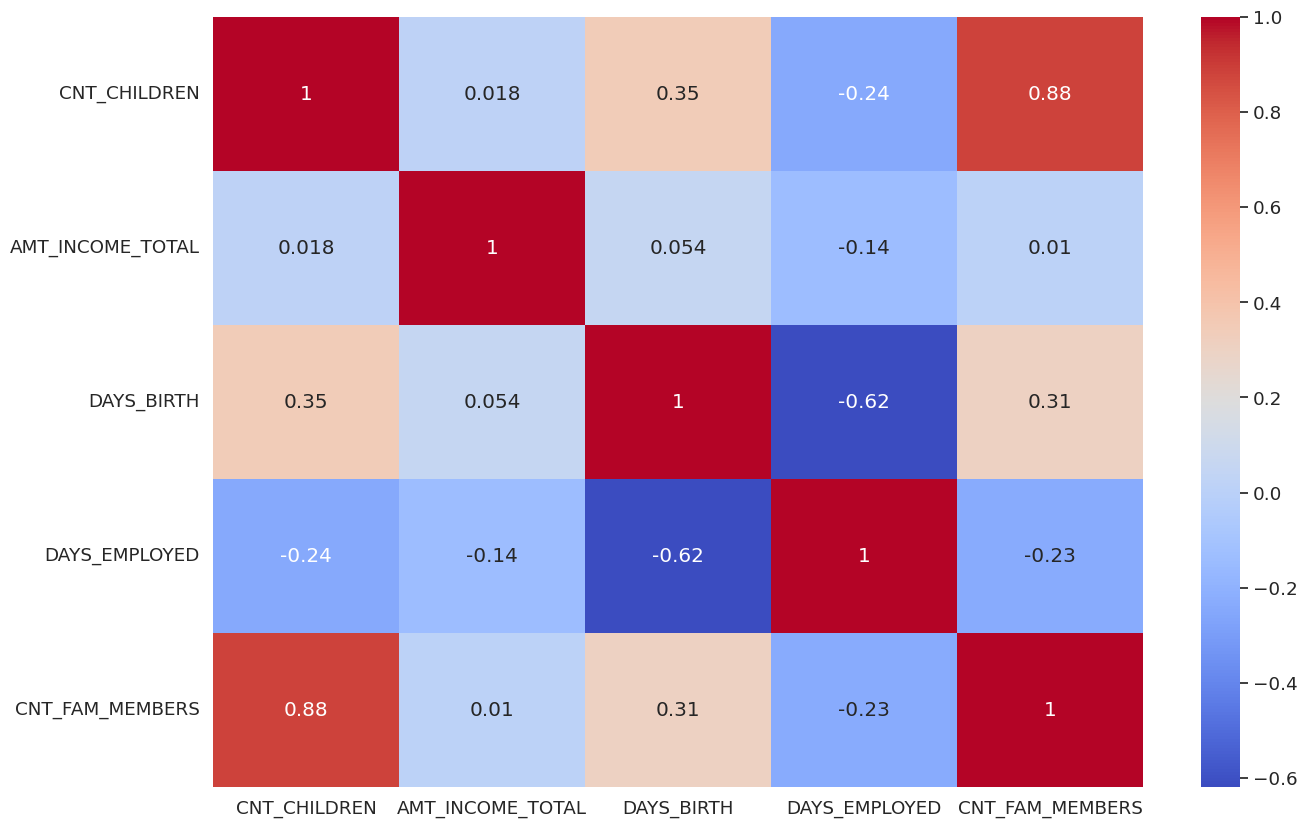

In [49]:
graficar_corr_num(caract_num)

#### Agrupación de características categóricas

In [50]:
caract_categ = X_train[lst_caract_categ]
caract_categ.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL
358501,F,N,Y,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0
115820,M,N,N,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0
140501,F,N,N,Working,Incomplete higher,Married,House / apartment,1,0,0,0
163776,F,Y,Y,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0
220527,F,N,N,Commercial associate,Higher education,Married,Municipal apartment,1,0,0,0


In [53]:
def medir_ind_caract_vs_target(data, target):
    for columna in data.columns.values.tolist():
        tablaContingencia= pd.crosstab(data[columna], target)
        chi2, p, dof, ex = chi2_contingency(tablaContingencia.values)
        print(str(columna) + " - " + "target")
        print('Chi-square Statistic %0.3f p_value %0.3f' % (chi2, p) + "\r\n")

#### Se identifican a las características relevantes

In [54]:
medir_ind_caract_vs_target(caract_categ, y_train)

CODE_GENDER - target
Chi-square Statistic 0.264 p_value 0.608

FLAG_OWN_CAR - target
Chi-square Statistic 0.824 p_value 0.364

FLAG_OWN_REALTY - target
Chi-square Statistic 1.439 p_value 0.230

NAME_INCOME_TYPE - target
Chi-square Statistic 0.475 p_value 0.976

NAME_EDUCATION_TYPE - target
Chi-square Statistic 2.847 p_value 0.584

NAME_FAMILY_STATUS - target
Chi-square Statistic 2.260 p_value 0.688

NAME_HOUSING_TYPE - target
Chi-square Statistic 7.646 p_value 0.177

FLAG_MOBIL - target
Chi-square Statistic 0.000 p_value 1.000

FLAG_WORK_PHONE - target
Chi-square Statistic 6.143 p_value 0.013

FLAG_PHONE - target
Chi-square Statistic 0.006 p_value 0.940

FLAG_EMAIL - target
Chi-square Statistic 0.478 p_value 0.489



#### Se eliminan las características redundantes o irrelevantes

In [56]:
caract_num_v1 = caract_num.drop(columns=['CNT_FAM_MEMBERS']).copy()
caract_categ_v1 = caract_categ.drop(columns=['FLAG_WORK_PHONE']).copy()

### Normalización de los valores de las características numéricas

In [57]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [58]:
scaler_v1 = MinMaxScaler()
columnas_v1 = caract_num_v1.columns
d_v1 = scaler_v1.fit_transform(caract_num_v1)
caract_num_train_nor_v1 = pd.DataFrame(d_v1, columns=columnas_v1)

caract_num_train_nor_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED
0,0.000000,0.039620,0.168078,1.000000
1,0.052632,0.019542,0.859756,0.041973
2,0.105263,0.006826,0.815210,0.040011
3,0.000000,0.019542,0.282633,1.000000
4,0.000000,0.026235,0.294207,0.033069


### Aplicación del One-hot Encoding sobre las características categóricas

In [60]:
encoder_v1 = OneHotEncoder(handle_unknown='ignore')
d_v1 = encoder_v1.fit_transform(caract_categ_v1)
caract_categ_train_ohe_v1 = pd.DataFrame(d_v1.toarray(), columns=encoder_v1.get_feature_names_out())

caract_categ_train_ohe_v1.head()

,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### Formación del subset de entrenamiento preprocesado

In [61]:
X_train_v1 = pd.concat([caract_num_train_nor_v1, caract_categ_train_ohe_v1], axis = 1)
X_train_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,0.000000,0.039620,0.168078,1.000000,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.052632,0.019542,0.859756,0.041973,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.105263,0.006826,0.815210,0.040011,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.000000,0.019542,0.282633,1.000000,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.000000,0.026235,0.294207,0.033069,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


### Aplicación de SMOTE y RandomUnderSampler

In [52]:
!pip install imbalanced-learn

In [62]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [63]:
counter = Counter(y_train)
print(counter)

Counter({0: 329795, 1: 21050})


In [64]:
over = SMOTE(sampling_strategy=0.1, random_state=1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_gen, y_train_gen = pipeline.fit_resample(X_train_v1, y_train)

In [65]:
counter = Counter(y_train_gen)
print(counter)

Counter({0: 65958, 1: 32979})


## Construcción de los modelos

In [58]:
!pip install xgboost

In [68]:
from xgboost import XGBClassifier

In [69]:
xgb_v1 = XGBClassifier().fit(X_train_gen, y_train_gen)

In [70]:
xgb_v1.score(X_train_gen, y_train_gen)

0.7681757077736338

## Fase de prueba de los modelos

In [72]:
X_test.drop(columns=columnas_eliminadas, inplace=True)
X_test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
264116,F,N,Y,0,99000.0,Working,Secondary / secondary special,Married,House / apartment,-17960,-2854,1,1,1,0,2.0
265876,M,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,-19972,365243,1,0,1,0,2.0
413600,M,Y,Y,0,171000.0,Pensioner,Higher education,Married,House / apartment,-23793,365243,1,0,0,0,2.0
281064,F,N,N,0,135000.0,Working,Secondary / secondary special,Civil marriage,Rented apartment,-16721,-2661,1,0,1,0,2.0
67233,F,N,Y,0,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23507,365243,1,0,0,0,2.0


In [73]:
cols = X_test.isna().sum()
print(cols)

CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
CNT_FAM_MEMBERS        0
dtype: int64


In [74]:
caract_num_test_v1 = X_test[caract_num_v1.columns.tolist()].copy()


In [75]:
for columna in caract_num_test_v1.columns.tolist():
    media_caract = medias_dict[columna]
    caract_num_test_v1[columna].replace(np.nan, media_caract, inplace=True)

In [76]:
caract_categ_test_v1 = X_test[caract_categ_v1.columns.tolist()].copy()

for columna in caract_categ_test_v1.columns.tolist():
    moda_caract = modas_dict[columna]
    caract_categ_test_v1[columna].replace(np.nan, moda_caract, inplace=True)

In [77]:
X_test = pd.concat([caract_num_test_v1, caract_categ_test_v1], axis = 1)
cols = X_test.isna().sum()
print(cols)

CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
FLAG_MOBIL             0
FLAG_PHONE             0
FLAG_EMAIL             0
dtype: int64


In [78]:
columnas_1 = caract_num_test_v1.columns
d_1 = scaler_v1.transform(caract_num_test_v1)
caract_num_test_nor_v1 = pd.DataFrame(d_1, columns=columnas_1)

caract_num_test_nor_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED
0,0.0,0.010842,0.408819,0.038344
1,0.0,0.019542,0.295224,1.000000
2,0.0,0.021550,0.079494,1.000000
3,0.0,0.016196,0.478771,0.038848
4,0.0,0.009503,0.095641,1.000000


In [79]:
d_1 = encoder_v1.transform(caract_categ_test_v1)
caract_categ_test_ohe_v1 = pd.DataFrame(d_1.toarray(), columns=encoder_v1.get_feature_names_out())

caract_categ_test_ohe_v1.head()

,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [80]:
X_test_v1 = pd.concat([caract_num_test_nor_v1, caract_categ_test_ohe_v1], axis = 1)
X_test_v1.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CODE_GENDER_F,CODE_GENDER_M,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,...,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,FLAG_MOBIL_1,FLAG_PHONE_0,FLAG_PHONE_1,FLAG_EMAIL_0,FLAG_EMAIL_1
0,0.0,0.010842,0.408819,0.038344,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.0,0.019542,0.295224,1.000000,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,0.0,0.021550,0.079494,1.000000,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.016196,0.478771,0.038848,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,0.0,0.009503,0.095641,1.000000,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [81]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [82]:
y_xgb_v1_pred = xgb_v1.predict(X_test_v1)

In [83]:
accuracy_score(y_test, y_xgb_v1_pred)

0.9265322874863189

In [84]:
f1_score(y_test, y_xgb_v1_pred)

0.027467552067612436

In [85]:
print(classification_report(y_test, y_xgb_v1_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     82449
           1       0.07      0.02      0.03      5263

    accuracy                           0.93     87712
   macro avg       0.50      0.50      0.49     87712
weighted avg       0.89      0.93      0.91     87712

